In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from jax import vmap, jit
import jax.numpy as jnp
from pathlib import Path
import numpy as np
from einops import rearrange
import jax
import matplotlib.pyplot as plt
import seaborn as sns
from hflow.misc.plot import scatter_movie, imshow_movie, line_movie
from hflow.run import build
from hflow.io.load import load_single, load_multi
import random

In [3]:
cfg, row = load_single('osc', '171320612808')
key, data, loss_fn, arg_fn, s_fn, params_init = build(cfg)
(sols, mus, t) = data
opt_params = row['opt_params']

In [5]:
from hflow.test.test import solve_test_sde
from hflow.misc.jax import get_rand_idx

t_int = np.linspace(0.0, 3.0, len(t))
dt = 1e-3
mu_i = 0
samples_idx = get_rand_idx(key, sols.shape[2], 10_000)
ics = sols[:, 0, samples_idx, :]
test_sol = solve_test_sde(s_fn, row['opt_params'], ics[mu_i], t_int, dt, row['loss-sigma'], mus[mu_i], key)

In [6]:
scatter_movie(test_sol, t=t_int)

In [7]:
s_Vx = vmap(s_fn, in_axes=(None, 0, None))
s_Vx_Vt = vmap(s_Vx, in_axes=(0, None, None))

In [12]:
from hflow.misc.misc import pts_array_from_space
nx = 75
xx = jnp.linspace(0,1,nx)
x_grid = pts_array_from_space([xx,xx])

mu_t = jnp.stack([jnp.ones_like(t_int)* mus[mu_i], t_int]).T
pred = s_Vx_Vt(mu_t, x_grid, opt_params)
pred = rearrange(pred, 'T (N1 N2)-> (T) N1 N2', T=len(t_int), N1=nx, N2=nx)

imshow_movie(pred, live_cbar=True, t=t_int)


In [9]:
from hflow.net.get import get_colora
u_fn, h_fn, params_init = get_colora(cfg.unet, cfg.hnet, data, key)

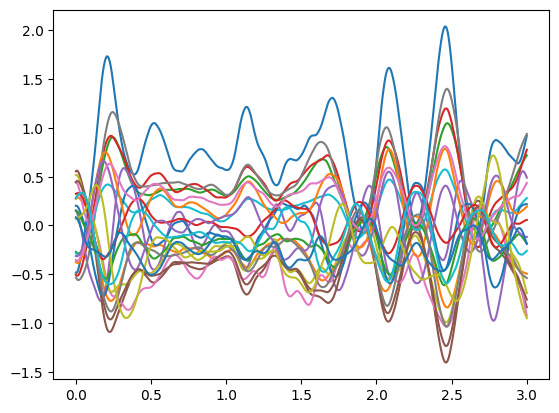

In [10]:
phis = vmap(h_fn, (None, 0))(opt_params[0], mu_t)
plt.plot(mu_t[:, -1], phis)
plt.show()